# Analysis of Data from Ice c. 2016

## Introduction

The purpose of this study is to determine the sales patterns of various games sold by Ice to determine whether or not they will succeed on the open market, which could open the way for focusing advertising on those products that could guarantee the most sucesss.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

file_path = '/datasets/games.csv'
df = pd.read_csv(file_path)

## Basic Formatting

### Columns work

In [2]:
df.columns = [col.lower() for col in df.columns]
df.info()

df['user_score'].replace('tbd', np.nan, inplace=True)

df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')
df['user_score'] = df['user_score'].round(1)

print(df['year_of_release'].unique())
print(df['user_score'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
[2006. 1985. 2008. 2009. 1996. 1989. 1984. 2005. 1999. 2007. 2010. 2013.
 2004. 1990. 1988. 2002. 2001. 2011. 1998. 2015. 2012. 2014. 1992. 1997.
 1993. 1994. 1982. 2016. 2003. 1986. 2000.   nan 1995. 1991. 1981. 1987.
 1980. 1983.]
[8.  nan

A number of columns have been changed from objects to Int64 float types to better handle any possible missing values and enable better analysis of the data by turning it into a numerical system that can be recognized.

### Missing Values

In [3]:
missing_data = df.isnull().sum()
print(missing_data)

df = df.dropna(subset=['year_of_release'])
print(df.isnull().sum())

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64
name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         8983
rating             6678
dtype: int64


For the "TBD" value, many values to be determined could be there because they did not have a critic or user score, or an ESRB rating at the time of recording the dataset. I simply chose to leave it in place.

As for the rest, those mainly had missing years, so that was decided by marking it with 0 until it could be filled.

For missing values, a number of factors could be the cause of this, including:
* For year of release, it could be chalked up to incomplete historical records or any data entry errors.
* Review scores can be justified by the fact that some games might not have had any reviews from either users and professional critics.

For missing year values, the decision was taken to simply ignore the rows containing them (some 269 total), if only to ensure the integrity of our analysis.

### Duplicate Values

In [4]:
duplicate_values = df.duplicated()
print(f'Number of duplicate values:, {duplicate_values.shape[0]}')

df = df.drop_duplicates()

Number of duplicate values:, 16446


There are a number of duplicate values which show up on this dataset, which could be explained by either human error, combined datasets from different sources, or just actual multiple listings in the dataset.

In [5]:
duplicate_name_year_platform = df[df.duplicated(subset=['name', 'year_of_release', 'platform'])]
print(f'Number of name-year-platform duplicate rows: {duplicate_name_year_platform.shape[0]}')

df = df.drop_duplicates(subset=['name', 'year_of_release', 'platform'])

Number of name-year-platform duplicate rows: 2


## Analysis of Data (Total)

### Total Sales (dataset)

In [6]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


So far, the dataset for the most part includes much of the data we would need to do some through analysis by region, sales figures, and review scores to press forward. 

### Number of Games per Year

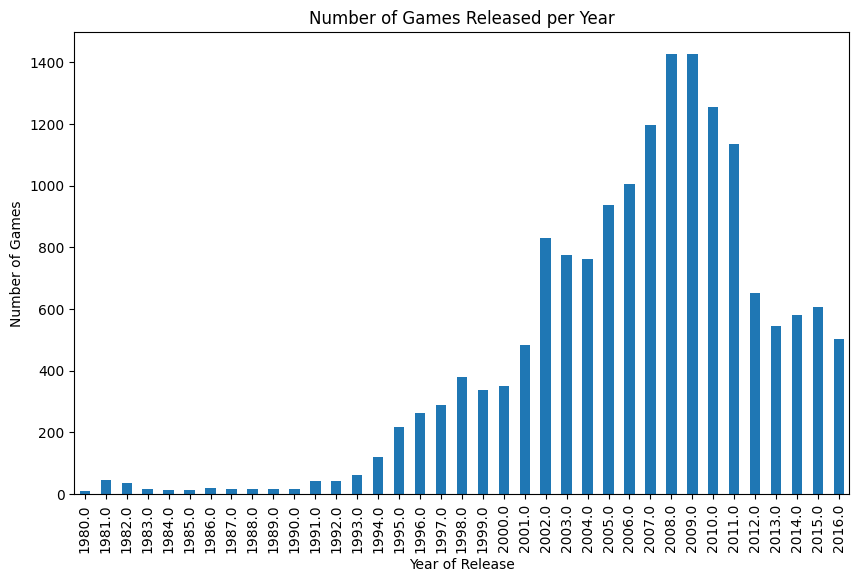

In [7]:
games_per_year = df['year_of_release'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
games_per_year.plot(kind='bar')
plt.title('Number of Games Released per Year')
plt.xlabel('Year of Release')
plt.ylabel('Number of Games')
plt.show()

Most of the games being sold were made relatively recently (data from 2016), with most of the games from 2006 to 2011 (that is five to ten years ago).

### Total Sales by Platform

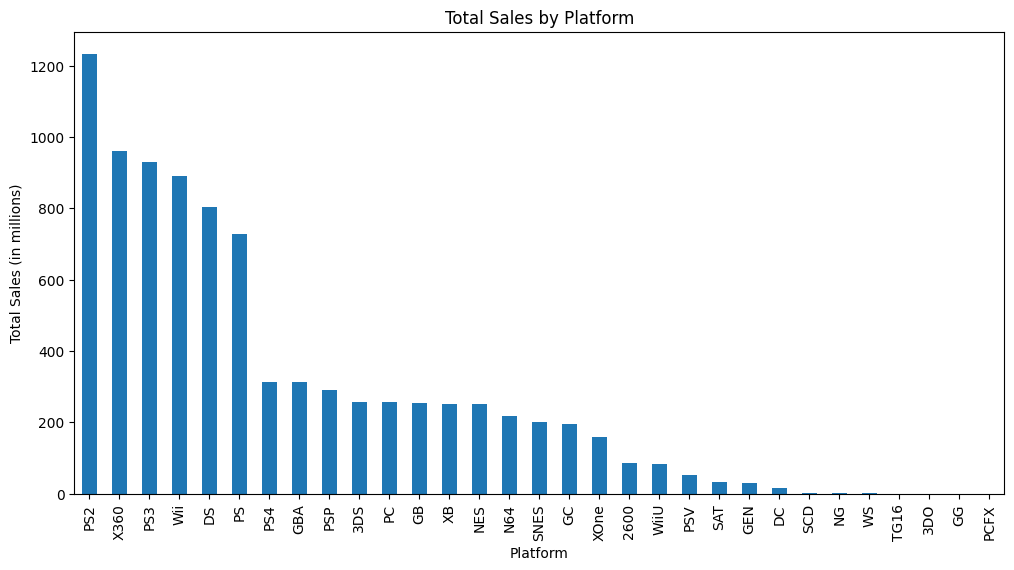

In [8]:
platform_sales = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
platform_sales.plot(kind='bar')
plt.title('Total Sales by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales (in millions)')
plt.show()

By far the most successful platform sold is the PlayStation 2, with over 1.250 trillion units sold over its entire lifespan. The next successful are the XBOX 360, the PlayStation 3, the Wii, and Nintendo DS.

### Yearly Sales by Platform

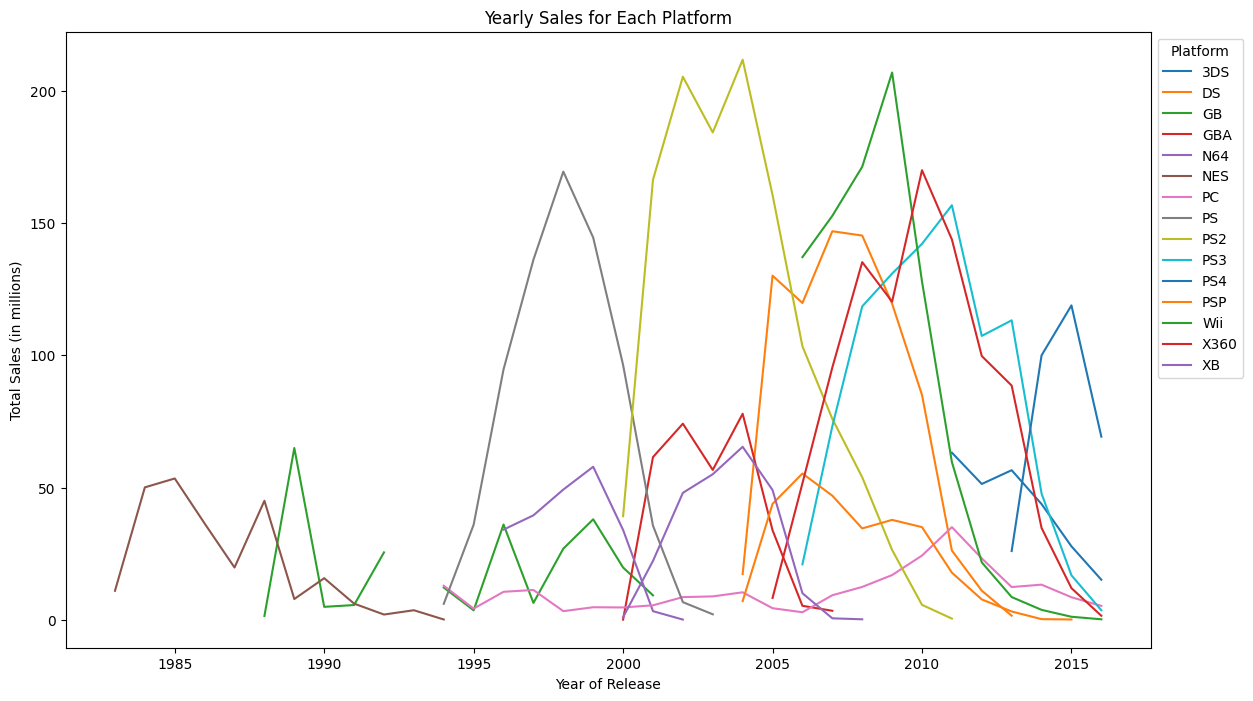

In [9]:
df_filtered = df[df['year_of_release'] >= 1980]
top_platforms = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(15).index
top_platforms_data = df[df['platform'].isin(top_platforms)]
sales_per_platform_per_year = top_platforms_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

plt.figure(figsize=(14, 8))
for platform in sales_per_platform_per_year.columns:
    plt.plot(sales_per_platform_per_year.index, sales_per_platform_per_year[platform], label=platform)

plt.title('Yearly Sales for Each Platform')
plt.xlabel('Year of Release')
plt.ylabel('Total Sales (in millions)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Platform')
plt.show()

The second graphs also shows how each platform's sales fared over the course of decades, with a pattern that each platform has an average sales lifespan of around 5-7 years or so, dropping around the time that a superior offering is being sold.

## Analysis of Data (from 2013 onward)

In [10]:
relevant_data = df[df['year_of_release'] >= 2013]

### Leading Platform

In [11]:
top_platforms = relevant_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5)
print(top_platforms)

platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
Name: total_sales, dtype: float64


With this in mind, the PlayStation system continues to be the dominant platform, with the PlayStation 4 the dominant platform alongside the PlayStation 3, while the XBOX One is a close third. The Nintendo 3DS and the XBOX 360 round out the total sales. If we look at the trends by each platform...

In [12]:
recent_data = df[df['year_of_release'] >= 2013]

top_platforms = recent_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index
top_platforms_data = recent_data[recent_data['platform'].isin(top_platforms)]

year_platform_sales = df.groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()

pivot_table = top_platforms_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
print(pivot_table)

platform           3DS     PS3     PS4   X360   XOne
year_of_release                                     
2013.0           56.57  113.25   25.99  88.58  18.96
2014.0           43.76   47.76  100.00  34.74  54.07
2015.0           27.78   16.82  118.90  11.96  60.14
2016.0           15.14    3.60   69.25   1.52  26.15


<Figure size 1400x800 with 0 Axes>

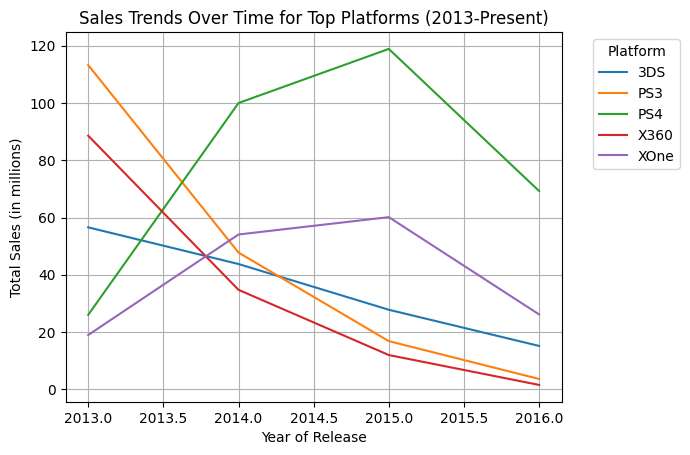

In [13]:
plt.figure(figsize=(14, 8))
pivot_table.plot(kind='line')
plt.title('Sales Trends Over Time for Top Platforms (2013-Present)')
plt.xlabel('Year of Release')
plt.ylabel('Total Sales (in millions)')
plt.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

... we can actually see that both the PlayStation 3 and XBOX 360 (alongside the Nintendo 3DS) were actually declining around the timeframe in question, with sales figures for the three platforms all declining by this period, while figures for both the PlayStation 4 and XBOX One increasing around that time, peaking in 2015.

### Global Sales by Platform

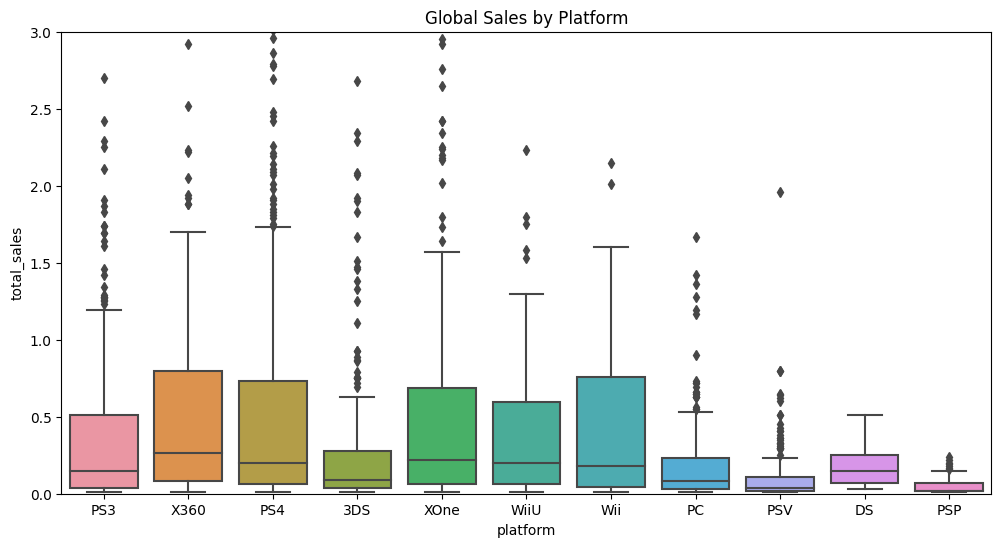

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='platform', y='total_sales', data=relevant_data)
plt.title('Global Sales by Platform')
plt.ylim (top=3, bottom=0)
plt.show()

In terms of global sales by platform, there's a relatively even spread among platforms, with many of the modern systems (the PlayStation 3 and PlayStation 4, and the XBOX 360 and XBOX One) having higher averages compared to most others.

Many of the outliers also inidicate that because games were sorted by platform, there were cases in which games on said platforms are so popular that they sell well outside the average.

### Correlation between User and Professional Reviews vs Total Sales

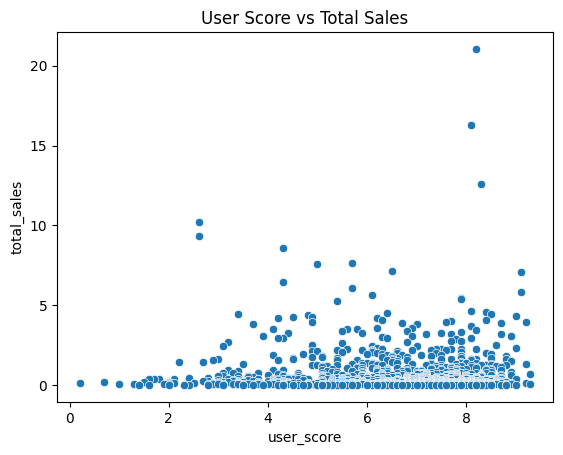

             user_score  total_sales
user_score     1.000000    -0.002608
total_sales   -0.002608     1.000000


In [15]:
sns.scatterplot(x='user_score', y='total_sales', data=relevant_data)
plt.title('User Score vs Total Sales')
plt.show()

correlation = relevant_data[['user_score', 'total_sales']].corr()
print(correlation)

As you can see, there is a general correlation between user scores and the total sales of each game, with higher scores (highest being 8) translating to higher sales overall. We can actually further break it down by the sales of the two most popular video game platforms in recent years (the PlayStation 4 and XBOX One).

All three platforms (shown below) show similar correlations, with a similar bump as rating scores increase up to a peak of 8.0 and above.

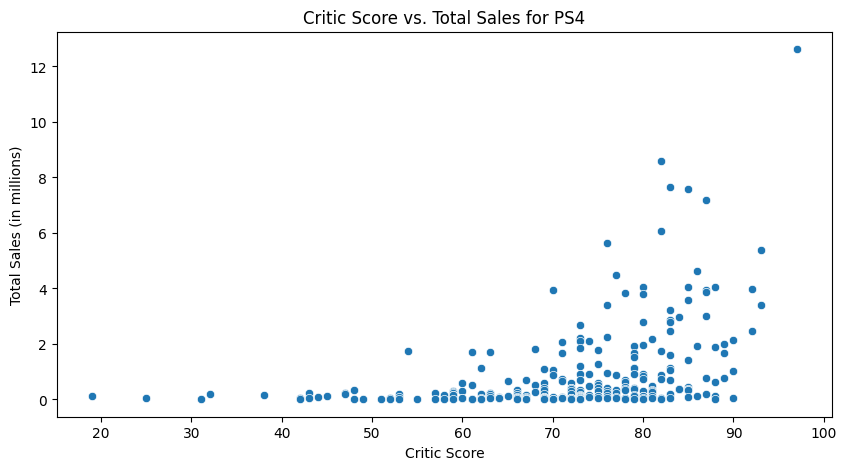

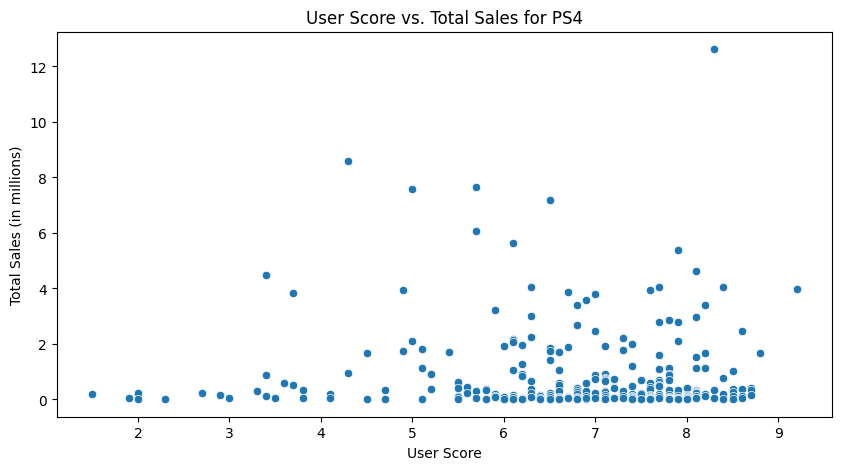

Correlation between Critic Score and Total Sales for PS4: 0.40656790206178095
Correlation between User Score and Total Sales for PS4: -0.031957110204556424


In [16]:
chosen_platform = 'PS4'
platform_data = df[df['platform'] == chosen_platform]

plt.figure(figsize=(10, 5))
sns.scatterplot(x=platform_data['critic_score'], y=platform_data['total_sales'])
plt.title(f'Critic Score vs. Total Sales for {chosen_platform}')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales (in millions)')
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=platform_data['user_score'], y=platform_data['total_sales'])
plt.title(f'User Score vs. Total Sales for {chosen_platform}')
plt.xlabel('User Score')
plt.ylabel('Total Sales (in millions)')
plt.show()

critic_corr = platform_data['critic_score'].corr(platform_data['total_sales'])
user_corr = platform_data['user_score'].corr(platform_data['total_sales'])

print(f"Correlation between Critic Score and Total Sales for {chosen_platform}: {critic_corr}")
print(f"Correlation between User Score and Total Sales for {chosen_platform}: {user_corr}")

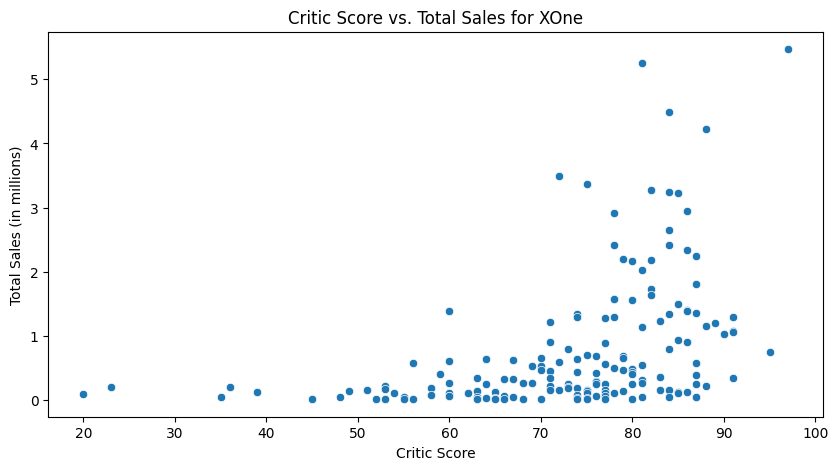

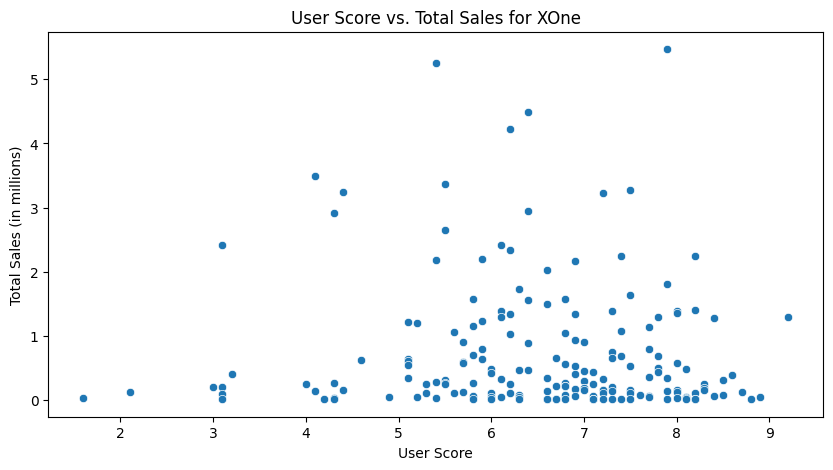

Correlation between Critic Score and Total Sales for XOne: 0.4169983280084017
Correlation between User Score and Total Sales for XOne: -0.06892505328279414


In [17]:
chosen_platform = 'XOne'
platform_data = df[df['platform'] == chosen_platform]

plt.figure(figsize=(10, 5))
sns.scatterplot(x=platform_data['critic_score'], y=platform_data['total_sales'])
plt.title(f'Critic Score vs. Total Sales for {chosen_platform}')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales (in millions)')
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=platform_data['user_score'], y=platform_data['total_sales'])
plt.title(f'User Score vs. Total Sales for {chosen_platform}')
plt.xlabel('User Score')
plt.ylabel('Total Sales (in millions)')
plt.show()

critic_corr = platform_data['critic_score'].corr(platform_data['total_sales'])
user_corr = platform_data['user_score'].corr(platform_data['total_sales'])

print(f"Correlation between Critic Score and Total Sales for {chosen_platform}: {critic_corr}")
print(f"Correlation between User Score and Total Sales for {chosen_platform}: {user_corr}")

As can be seen in the two sets of graphs shown above, both the XBOX One and PlayStation 4 exhibited similar trends in terms of both critic and user scores to total sales per game (with some outliers), which does lend credence to this idea that sales increase as user and critic scores increase (indicating that they are more popular with consumers).

### Analysis of Sales per Genre

In [18]:
genre_sales = relevant_data.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
print(genre_sales)

genre
Action          321.87
Shooter         232.98
Sports          150.65
Role-Playing    145.89
Misc             62.82
Platform         42.63
Racing           39.89
Fighting         35.31
Adventure        23.64
Simulation       21.76
Strategy         10.08
Puzzle            3.17
Name: total_sales, dtype: float64


Of the genres, the top three-selling game genres (in terms of total sales) are action games (at 321.9 billion units sold), shooters (at 233 billion), and sports games (at 150.7 billion).

Of course, in order to more accurately gauge the average number of sales per genre, we'd have to split it up by game and compare it in there:

In [19]:
genre_group = relevant_data.groupby('genre').agg({
    'total_sales': ['sum', 'mean', 'median'],
    'name': 'count'
}).reset_index()

genre_group.columns = ['genre', 'total_sales', 'avg_sales', 'median_sales', 'number_of_games']

print(genre_group)

           genre  total_sales  avg_sales  median_sales  number_of_games
0         Action       321.87   0.420196         0.110              766
1      Adventure        23.64   0.096490         0.030              245
2       Fighting        35.31   0.441375         0.125               80
3           Misc        62.82   0.405290         0.100              155
4       Platform        42.63   0.576081         0.225               74
5         Puzzle         3.17   0.186471         0.060               17
6         Racing        39.89   0.469294         0.120               85
7   Role-Playing       145.89   0.499623         0.125              292
8        Shooter       232.98   1.245882         0.450              187
9     Simulation        21.76   0.350968         0.100               62
10        Sports       150.65   0.703972         0.240              214
11      Strategy        10.08   0.180000         0.080               56


In [20]:
sorted_by_avg_sales = genre_group.sort_values(by='avg_sales', ascending=False)
print("Genres sorted by average sales per game:")
print(sorted_by_avg_sales)

sorted_by_median_sales = genre_group.sort_values(by='median_sales', ascending=False)
print("Genres sorted by median sales per game:")
print(sorted_by_median_sales)

Genres sorted by average sales per game:
           genre  total_sales  avg_sales  median_sales  number_of_games
8        Shooter       232.98   1.245882         0.450              187
10        Sports       150.65   0.703972         0.240              214
4       Platform        42.63   0.576081         0.225               74
7   Role-Playing       145.89   0.499623         0.125              292
6         Racing        39.89   0.469294         0.120               85
2       Fighting        35.31   0.441375         0.125               80
0         Action       321.87   0.420196         0.110              766
3           Misc        62.82   0.405290         0.100              155
9     Simulation        21.76   0.350968         0.100               62
5         Puzzle         3.17   0.186471         0.060               17
11      Strategy        10.08   0.180000         0.080               56
1      Adventure        23.64   0.096490         0.030              245
Genres sorted by median

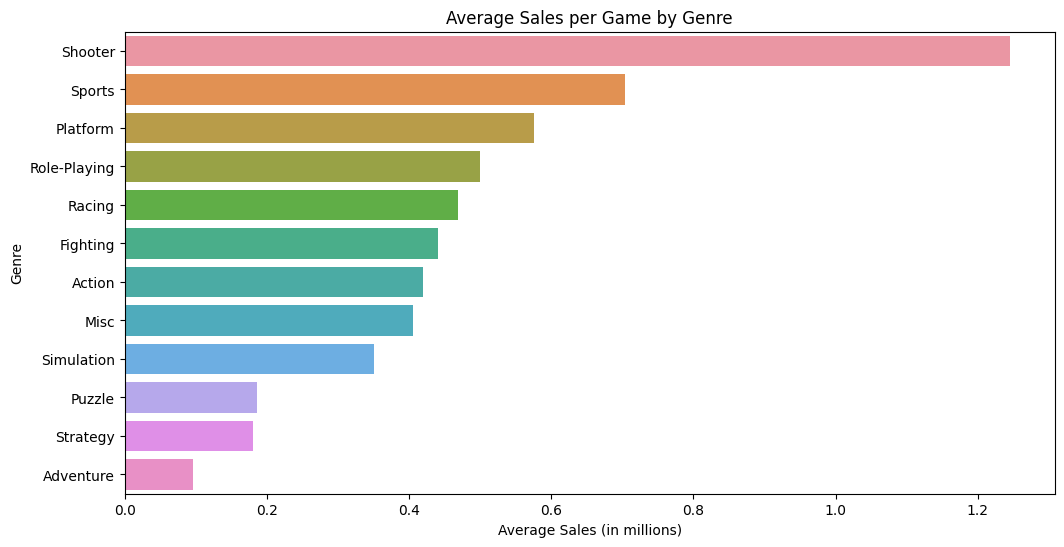

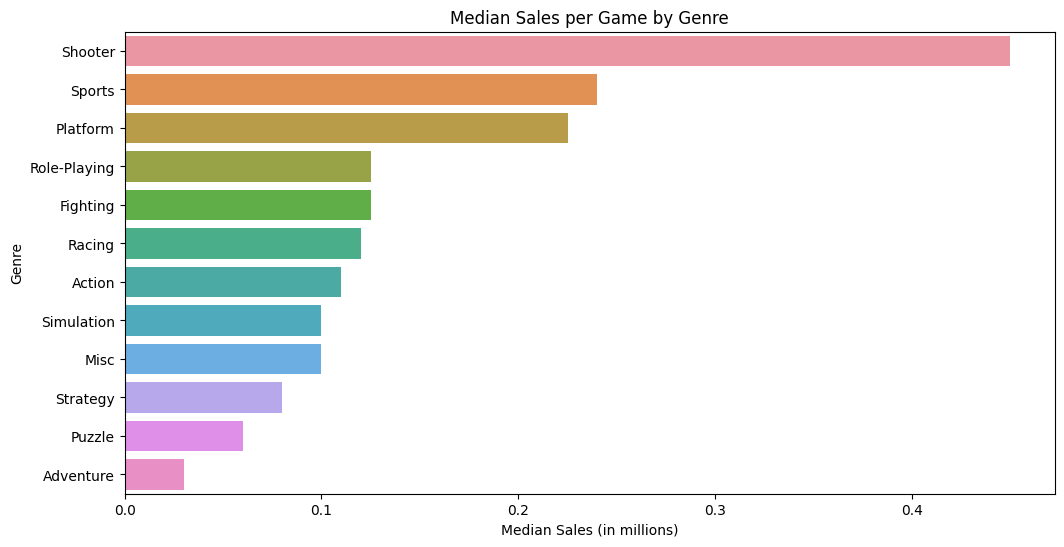

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_sales', y='genre', data=sorted_by_avg_sales)
plt.title('Average Sales per Game by Genre')
plt.xlabel('Average Sales (in millions)')
plt.ylabel('Genre')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='median_sales', y='genre', data=sorted_by_median_sales)
plt.title('Median Sales per Game by Genre')
plt.xlabel('Median Sales (in millions)')
plt.ylabel('Genre')
plt.show()

While action games dominate the industry in terms of number of games sold and total volume of sales, shooter games by far dominate both in terms of average and median sales per game, with sports games at second and platform games at third.

## Analysis of Data (Region-by-Region)

The following is a region-by-region analysis of the data before us, as well as some conjecture...

In [22]:
na_platform_sales = relevant_data.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_platform_sales = relevant_data.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_platform_sales = relevant_data.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

na_genre_sales = relevant_data.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_genre_sales = relevant_data.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_genre_sales = relevant_data.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

### Top Five Platforms by Region

In [23]:
print("Top 5 Platforms in North America:")
print(na_platform_sales)

print("Top 5 Platforms in Europe:")
print(eu_platform_sales)

print("Top 5 Platforms in Japan:")
print(jp_platform_sales)

Top 5 Platforms in North America:
platform
PS4     108.74
XOne     93.12
X360     81.66
PS3      63.50
3DS      38.20
Name: na_sales, dtype: float64
Top 5 Platforms in Europe:
platform
PS4     141.09
PS3      67.81
XOne     51.59
X360     42.52
3DS      30.96
Name: eu_sales, dtype: float64
Top 5 Platforms in Japan:
platform
3DS     67.81
PS3     23.35
PSV     18.59
PS4     15.96
WiiU    10.88
Name: jp_sales, dtype: float64


Of the major platforms, the PlayStation 4 was particularly dominant in both the US and Europe by far, with the XBOX One taking second place in American markets and third in Europe. The XBOX 360 and PlayStation 3 are third and second in their respective regions.

Japan though is somewhat different, with portable platforms like the Nintendo 3DS, the PlayStation Vita (a sister platform to thr PlayStation consoles), and the Wii U among the top five platforms.

### Top Five Genres by Region

In [24]:
print("Top 5 Genres in North America:")
print(na_genre_sales)

print("Top 5 Genres in Europe:")
print(eu_genre_sales)

print("Top 5 Genres in Japan:")
print(jp_genre_sales)

Top 5 Genres in North America:
genre
Action          126.05
Shooter         109.74
Sports           65.27
Role-Playing     46.40
Misc             27.49
Name: na_sales, dtype: float64
Top 5 Genres in Europe:
genre
Action          118.13
Shooter          87.86
Sports           60.52
Role-Playing     36.97
Racing           20.19
Name: eu_sales, dtype: float64
Top 5 Genres in Japan:
genre
Role-Playing    51.04
Action          40.49
Misc             9.20
Fighting         7.65
Shooter          6.61
Name: jp_sales, dtype: float64


Here, there's a marked difference between Japan, and Europe and North America, in which action games, sports games, and shooters (in that order) dominated in both Europe and North America, while in Japan, role-playing games actually took the top prize, with action and sports games being second and third respectively.

### Do ESRB Scores affect Sales?

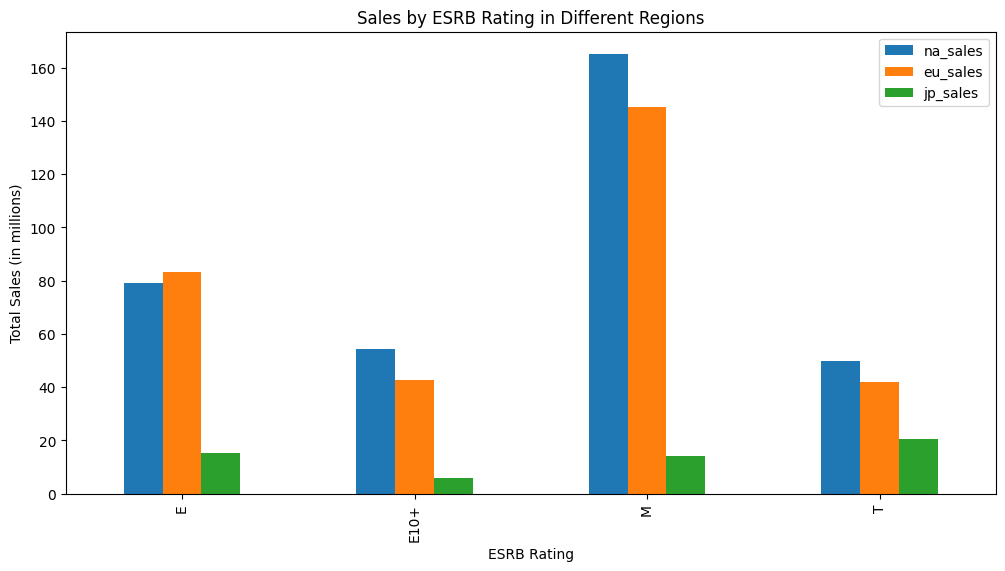

In [25]:
esrb_sales_by_region = relevant_data.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum()

esrb_sales_by_region.plot(kind='bar', figsize=(12, 6))
plt.title('Sales by ESRB Rating in Different Regions')
plt.xlabel('ESRB Rating')
plt.ylabel('Total Sales (in millions)')
plt.show()

For the most part, there seems to be a strong correlation between ESRB ratings and the total sales, with M-rated ("Mature") games by far dominating in all three regions, while E-rated ('for Everyone") at a distant second. E10+ ("for Everyone 10+") and T-rated ("Teen") games round out the table at third and fourth respectively.

## Hypotheses

The hypotheses to test are as follows:

**Hypothesis One: Are average user ratings for both the XBOX One and PC games the same?**  
*Null*: The average user ratings for Xbox One and PC platforms are the same.  
*Alternate*: The average user ratings for Xbox One and PC platforms are different.

**Hypothesis Two: Are average user ratings between action and sports games the same?**  
*Null*: The average user ratings for Action and Sports genres are the same.  
*Alternate*: The average user ratings for Action and Sports genres are different.

Alpha is set at 0.05

In [26]:
xbox_one_ratings = relevant_data[relevant_data['platform'] == 'XOne']['user_score'].dropna()
pc_ratings = relevant_data[relevant_data['platform'] == 'PC']['user_score'].dropna()

t_stat, p_value = stats.ttest_ind(xbox_one_ratings, pc_ratings)
alpha = 0.05

print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < alpha:
    print("Reject the null hypothesis: Average user ratings for Xbox One and PC platforms are different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average user ratings for Xbox One and PC platforms.")

T-statistic: 1.4788255981357277, P-value: 0.14012658403611647
Fail to reject the null hypothesis: No significant difference in average user ratings for Xbox One and PC platforms.


In [27]:
action_ratings = relevant_data[relevant_data['genre'] == 'Action']['user_score'].dropna()
sports_ratings = relevant_data[relevant_data['genre'] == 'Sports']['user_score'].dropna()

t_stat, p_value = stats.ttest_ind(action_ratings, sports_ratings)
alpha = 0.05

print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < alpha:
    print("Reject the null hypothesis: Average user ratings for Action and Sports genres are different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average user ratings for Action and Sports genres.")

T-statistic: 11.535100577928208, P-value: 1.0517832389140023e-27
Reject the null hypothesis: Average user ratings for Action and Sports genres are different.


## Conclusions

There are some conclusions to be gleaned from this latest study:

* As the hypothesis shows, average user ratings between Action and Sports genres were remarkably different from one other, with action games taking top spots in terms of total sales per genre compared to sports games.
* Also, there was no discernable difference between XBOX One sales and PC sales, which inidicates that online gaming might also cast a significant influence in total sales.

Overall, the company should try and focus on the platforms like the PlayStation 4 and XBOX One, with the former taking priority as the main platform. Meanwhile, M-rated action games and shooters are generally the best-performing and should be the first priority for sales promotions, followed by E-rated sports and platform games.